![](https://img.kaikeba.com/70350130700202jusm.png)

## 准备工作
导入本次项目要用到的库：<br>

In [2]:
import os 
import cv2 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import pickle 
import PIL
import matplotlib.pyplot as plt
from PIL import Image 
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 了解数据集
定义数据路径：<br>

In [3]:
train_data_dir = '/data/course_data/AI/AI_homework_verification_code//train_data.bin'
val_data_dir = '/data/course_data/AI/AI_homework_verification_code//val_data.bin'
verification_code_dir = '/data/course_data/AI/AI_homework_verification_code//verification_code_data.bin'

本次作业使用的数据集保存于二进制文件中，我们需要定义一个函数，读取二进制文件中的图片。<br>

In [4]:
def load_file(file_name):
    with open(file_name, mode='rb') as f:
        result = pickle.load(f)
    return result

下面让我们看看数据集是什么样<br>

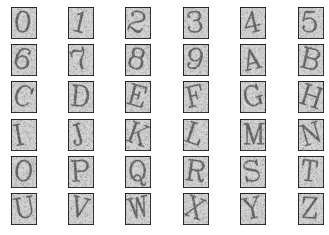

In [5]:
# 查看所有类别的图片
train_data = load_file(train_data_dir)
img_test = list()
for i in range(1,1800,50):
    img_test.append(train_data[i][1])
plt.figure()
for i in range(1,37):
    plt.subplot(6,6,i)
    plt.imshow(img_test[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()

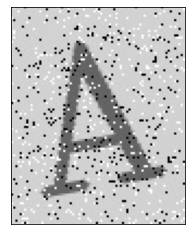

In [6]:
# 查看单张大图
plt.imshow(train_data[500][1])
plt.xticks([])
plt.yticks([])
plt.show()

可以看到，字符图片中含有大量的噪声，而噪声会对模型预测结果产生不良影响，因此我们可以在数据预处理时，使用特定的滤波器，消除图片噪声。<br>

## 问题1——建立字符对照表（10分）
我们需要将数据集中所存储的字符串格式的label转化为整形数字，以便模型计算损失时所用。<br>

In [7]:
char_dict = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,\
            'A':10,'B':11,'C':12,'D':13,'E':14,'F':15,'G':16,'H':17,'I':18,'J':19,'K':20,'L':21,'M':22,\
            'N':23,'O':24,'P':25,'Q':26,'R':27,'S':28,'T':29,'U':30,'V':31,'W':32,'X':33,'Y':34,'Z':35}

简单观察可知，刚才定义字符字典中，键与值都没有重复项，因此可以将字典中的键与值进行反转，以便我们用值查找键（将模型预测结果转换成可读字符）<br>
<font color=red>请补全下列代码，将字典中的键与值进行反转</font>（例：`dict={'A':10,'B':11}`反转后得到`new_dict={10:'A',11:'B'}`<br>

In [8]:
######## your code ########  
new_char_dict = {v : k for k, v in char_dict.items()}
print(new_char_dict)
######## your code ########

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


## 问题2——定义datasets与dataloader（10分）
我们需要使用`torch.utils.data.Dataset`作为父类，定义自己的datasets，以便规范自己的数据集。<br>

中值滤波器对椒盐噪声的消除效果很好，请用中值滤波器对读入的图片进行处理，减少图片噪声（滤波器核心尺寸可使用 5）。<br>

<font color=red>请补全`__getitem__`函数，使用中值滤波器减少图片噪声：</font><br>

In [9]:
class MyDataset(Dataset):
    def __init__(self, file_name, transforms):
        self.file_name = file_name # 文件名称
        self.image_label_arr = load_file(self.file_name) # 读入二进制文件
        self.transforms = transforms # 图片转换器

    def __getitem__(self, index):
        label, img = self.image_label_arr[index]
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # 将图片转为灰度图
        
        ######## your code ########
        img = cv2.medianBlur(img, 5)
        ######## your code ########
        
        img = self.transforms(img) # 对图片进行转换
        return img, char_dict[label[0]] 

    def __len__(self):
        return len(self.image_label_arr)

下面我们就可以定义transform和dataloader了。<br>

In [10]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([28,28]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

train_datasets = MyDataset(train_data_dir, transform)
train_loader = DataLoader(dataset=train_datasets,batch_size=32,shuffle=True)

val_datasets = MyDataset(val_data_dir, transform)
val_loader = DataLoader(dataset=val_datasets,batch_size=32,shuffle=True)

## 问题3——定义网络结构（40分）
在数据准备好之后，我们需要定义一个简单的卷积神经网络，神经网络的输入是`[batchsize,chanel(1),w(28),h(28)]`，输出是36个分类。<br>
我们的神经网络将使用2个卷积层搭配2个全连接层，这四层的参数设置如下表所示(未标注的直接使用默认参数即可)：<br>
1. conv1: in_channels=1, out_channels=10, kernel_size=5<br>
1. conv2: in_channels=10, out_channels=20, kernel_size=3<br>
1. fc1: in_features=2000, out_features=500<br>
1. fc2: in_features=500, out_features=36<br>
<font color=red>请根据上述参数，补全模型代码：</font><br>

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        ######## your code ########
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3) 
        self.fc1 = nn.Linear(in_features=2000, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=36)
        ######## your code ########
        
    def forward(self, x):
        # inputsize:[b,1,28,28]
        in_size = x.size(0) # b
        out= self.conv1(x) # inputsize:[b,1,28,28] -> outputsize:[b,10,24,24]
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2) # inputsize:[b,10,24,24] -> outputsize:[b,10,12,12]
        out = self.conv2(out) # inputsize:[b,10,12,12] -> outputsize:[b,20,10,10]
        out = F.relu(out)
        out = out.view(in_size, -1) # inputsize:[b,20,10,10] -> outputsize:[b,2000]
        out = self.fc1(out) # inputsize:[b,2000] -> outputsize:[b,500]
        out = F.relu(out)
        out = self.fc2(out) # inputsize:[b,500] -> outputsize:[b,36]
        out = F.log_softmax(out, dim = 1)
        return out

## 问题4——定义模型训练函数（40分）
<font color=red>请补全模型训练函数，实现如下操作：</font><br>
1. 清空梯度<br>
1. 前向传播<br>
1. 计算梯度<br>
1. 更新权重<br>

In [12]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        ######## your code ########
        optimizer.zero_grad() # 清空梯度（也可以放在最后一行）
        output = model(data) # 前向传播
        ######## your code ########
        
        loss = F.nll_loss(output, target)

        ######## your code ########
        loss.backward() # 计算梯度
        optimizer.step() # 更新权重
        ######## your code ########
        
        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## 定义模型测试函数

In [13]:
def test(model, test_loader):
    model.eval()
    test_loss =0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction = 'sum')
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n".format(
        test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)))

## 定义模型及优化器
我们将刚刚搭建好的模型结构定义为model，并选择使用Adam优化器。

In [14]:
model = ConvNet()
optimizer = optim.Adam(model.parameters())

## 模型训练与测试
我们可以先设置epochs数为3，进行模型训练，看看模型精度是多少，是否满足验证码识别的要求。<br>
如果模型精度不够，你还可以尝试调整epochs数，重新进行训练。<br>

In [15]:
EPOCHS = 3
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, val_loader)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [288/1800 (16%)]	Loss: 3.528542
Train Epoch: 1 [608/1800 (33%)]	Loss: 3.231778
Train Epoch: 1 [928/1800 (51%)]	Loss: 2.343240
Train Epoch: 1 [1248/1800 (68%)]	Loss: 1.449364
Train Epoch: 1 [1568/1800 (86%)]	Loss: 0.657342

Test set: Average loss: 0.3789, Accuracy: 322/360 (89%) 

Train Epoch: 2 [288/1800 (16%)]	Loss: 0.138864
Train Epoch: 2 [608/1800 (33%)]	Loss: 0.145200
Train Epoch: 2 [928/1800 (51%)]	Loss: 0.046560
Train Epoch: 2 [1248/1800 (68%)]	Loss: 0.168792
Train Epoch: 2 [1568/1800 (86%)]	Loss: 0.011831

Test set: Average loss: 0.0185, Accuracy: 360/360 (100%) 

Train Epoch: 3 [288/1800 (16%)]	Loss: 0.039626
Train Epoch: 3 [608/1800 (33%)]	Loss: 0.083438
Train Epoch: 3 [928/1800 (51%)]	Loss: 0.009845
Train Epoch: 3 [1248/1800 (68%)]	Loss: 0.021664
Train Epoch: 3 [1568/1800 (86%)]	Loss: 0.011936

Test set: Average loss: 0.0061, Accuracy: 360/360 (100%) 



模型已经训练完成了！你最后一个epoch的测试集精度是否超过了99%呢？

## 验证码识别
成功实现数字识别之后，我们就可以开始进行验证码识别了！<br>
首先要导入验证码数据集：<br>

In [16]:
verification_code_data = load_file(verification_code_dir)

下面我们随便选一张图（图6），看看这个验证码长什么样。

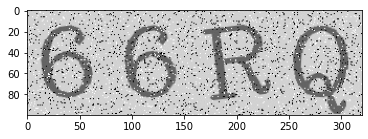

In [17]:
image = verification_code_data[6]
IMG = Image.fromarray(cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB))
plt.imshow(IMG)
plt.show()

下面我们再来看看中值滤波能对验证码图片产生什么效果。

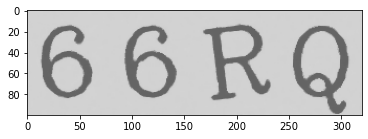

In [18]:
img = cv2.medianBlur(image.copy(), 5)
plt.imshow(img)
plt.show()

最后让我们看看验证码识别的实际结果：

In [19]:
IMAGES = list()
NUMS = list()

for img in verification_code_data:
    IMAGES.append(img)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    image_1 = img[:, :80]
    image_2 = img[:, 80:160]
    image_3 = img[:, 160:240]
    image_4 = img[:, 240:320]
    img_list = [image_1,image_2,image_3,image_4]
    
    nums = []
    for one_img in img_list:
        one_img = transform(one_img)
        one_img = one_img.unsqueeze(0)
        output = model(one_img)
        nums.append(new_char_dict[torch.argmax(output).item()])
    NUMS.append('Verification_code : '+''.join(nums))

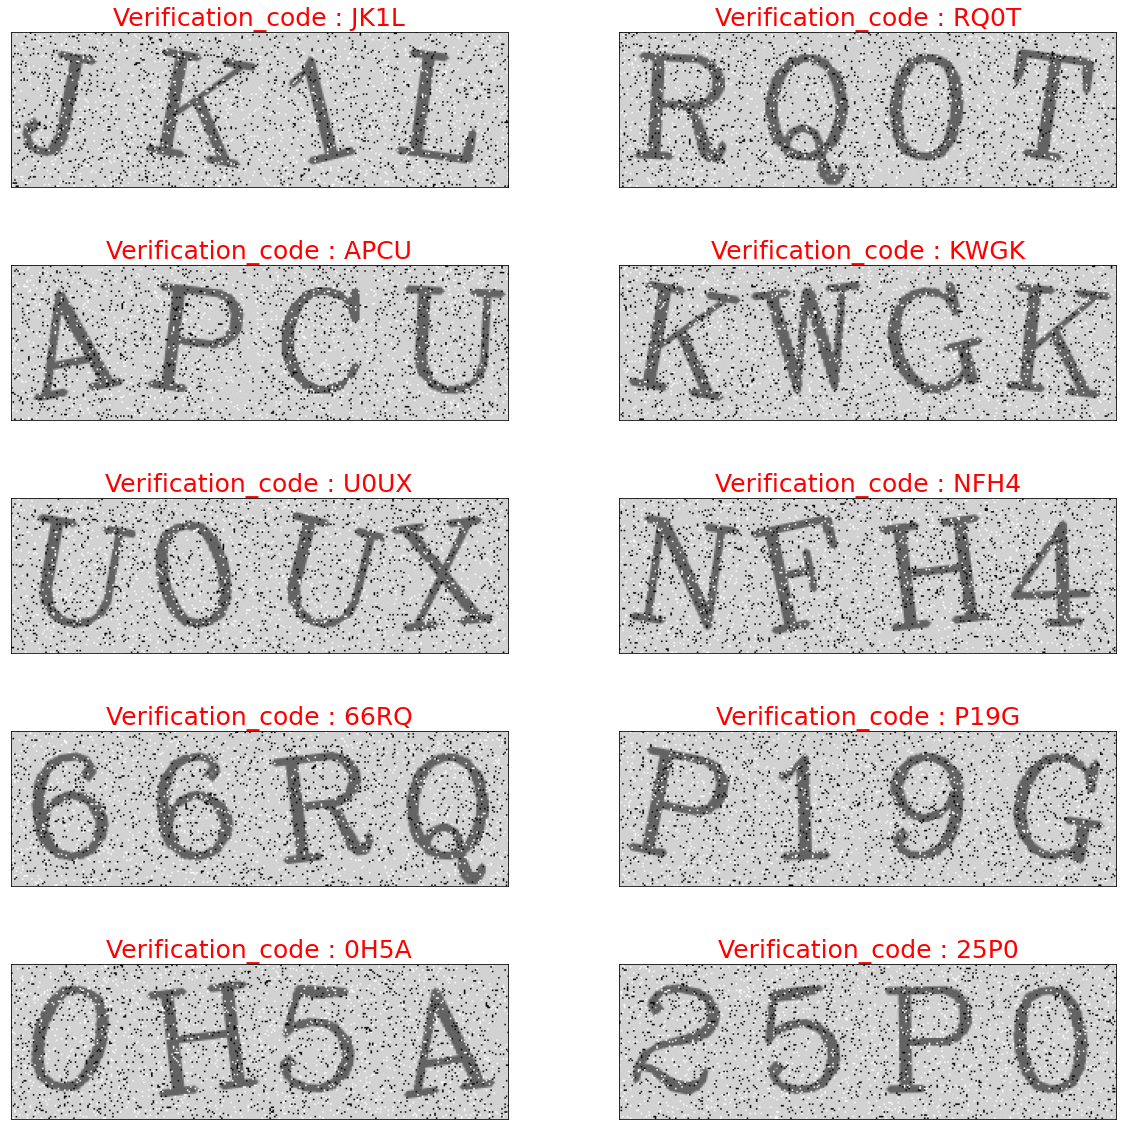

In [20]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(1,11):
    plt.subplot(5,2,i)
    plt.title(NUMS[i-1],fontsize=25,color='red')
    plt.imshow(IMAGES[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()